In [1]:
# -*- coding: utf-8 -*-
"""
The script demonstrates the performance of an interpolation algorithm when applied to a large dataset.
"""

bustime_filepath = '/gpfs2/projects/project-bus_capstone_2016/workspace/share/dec2015_extract_cleaned.csv'
code_filepath = '..'
output_filepath = '/gpfs2/projects/project-bus_capstone_2016/workspace/share/20151203_interpolated.csv'

import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# these modules are homemade
os.chdir(code_filepath)
import gtfs
import arrivals
import ttools

### Previous versions of the interpolation function. (final version is below)

### Current working version of interpolation function.
Takes several lists as inputs, which can be stored together as a dataframe row (merged_row).

merged_row.shape_stop_dist is a list of distances of *all* stops from the schedule on that shape.<p>
mergedrow.shape_stop_id is a list of stop_id labels for those stops<p>

## Get the Bus Time data

In [2]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv(bustime_filepath)

In [3]:
bustime.head()

,ROUTE_ID,latitude,longitude,recorded_time,vehicle_id,TRIP_ID,trip_date,SHAPE_ID,STOP_ID,distance_stop,distance_shape,status,destination
0,Q66,40.759376,-73.830754,2015-11-30T23:41:52.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
1,Q66,40.759376,-73.830754,2015-11-30T23:42:54.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
2,Q66,40.759376,-73.830754,2015-11-30T23:44:30.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
3,Q66,40.759376,-73.830754,2015-11-30T23:45:33.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
4,Q66,40.759376,-73.830754,2015-11-30T23:46:36.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066


#### Additional cleaning, organizing and sorting

In [4]:
bustime.drop_duplicates(['vehicle_id','recorded_time'],inplace=True)

bustime.set_index(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('recorded_time',append=True,drop=False,inplace=True)
bustime.sort_index(inplace=True)

# for demonstration, use a subset. Just get data one day.
tripDateLookup = '2015-12-03'
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)

In [5]:
bustime['distance_shape'] = bustime['distance_shape'].convert_objects(convert_numeric=True)
bustime['distance_stop'] = bustime['distance_stop'].convert_objects(convert_numeric=True)
# add calculated column for distance along shape
bustime['veh_dist_along_shape'] = bustime['distance_shape'] - bustime['distance_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


In [6]:
for name, group in bustime.groupby(level=2):
    bustime.loc[(slice(None),slice(None),name),'recorded_time'] = group['recorded_time'].apply(ttools.parseActualTime,tdate=name)

In [7]:
bustime.loc[(slice(None),slice(None),'2015-12-03'),'recorded_time'].head()

ROUTE_ID  TRIP_ID                           trip_date   vehicle_id  recorded_time          
B1        FB_D5-Weekday-SDon-047200_B49_15  2015-12-03  5125        2015-12-03T07:59:24.000   07:59:24
                                                                    2015-12-03T08:02:35.000   08:02:35
                                                                    2015-12-03T08:04:11.000   08:04:11
                                                                    2015-12-03T08:06:18.000   08:06:18
          FB_D5-Weekday-SDon-051000_B49_15  2015-12-03  4855        2015-12-03T08:52:39.000   08:52:39
Name: recorded_time, dtype: timedelta64[ns]

#### Create a separate dataframe containing the distances of ALL stops along each shape.
Although GTFS is the official source for all stop information, Bus Time has the distances calculated already according to the shape.  The problem is the records from each trip may not contain information about all the stops (for example, when some are skipped).  Using a large enough sample should resolve that problem.

In [8]:
bustime_distances = bustime.drop(['recorded_time'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','recorded_time',
                                                'latitude','longitude','distance_stop','status','destination',
                                                'veh_dist_along_shape'],axis=1,inplace=False)
stop_distances = bustime_distances.drop_duplicates(['SHAPE_ID','STOP_ID','distance_shape'])
stop_distances = stop_distances.query('distance_shape > 0.1')
stop_distances = stop_distances.sort(['SHAPE_ID','distance_shape']).reset_index(drop=True)

print 'Finished creating stop-distances reference dataframe.'

Finished creating stop-distances reference dataframe.


## Organization of Bus Time data
A trip is identified as the grouping of records for each route, trip date, trip_id **and** vehicle_id.  Both are required because sometimes trip_id labels are "recycled" during the day and used by two different vehicles serving the route.

In [9]:
gb = bustime.groupby(level=(0,1,2,3))

For each **trip data group**, take the reported shape_id (single value), which will be used next to get the information about all stops along that shape.<p>
From each group, take the necessary data in list form:
<ol>
<li>time stamps of all the pings</li>
<li>vehicle distances for thosee pings (note: Python list ordering is persistent, so the two lists can be kept separate)</li></ol>

In [10]:
shape_ids = gb['SHAPE_ID'].agg(lambda x:x.value_counts().index[0])
reported_timestamps = gb['recorded_time'].apply(list)
reported_dists = gb['veh_dist_along_shape'].apply(list)

... and also take the necessary data (in list form) from each **shape**:
<ol start="3">
<li>labels of all the stops along that shape, from the separate dataframe of stop distances</li>
<li>the distances of all those stops</li><ol>
<br>Also, rename the objects for clarity.  And then merge together.

In [11]:
all_stops = stop_distances.groupby('SHAPE_ID')['STOP_ID'].apply(list)
all_dists = stop_distances.groupby('SHAPE_ID')['distance_shape'].apply(list)
all_dists.name = 'shape_stop_dist'
all_stops.name = 'shape_stop_id'
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='SHAPE_ID',right_index=True).merge(pd.DataFrame(all_stops),left_on='SHAPE_ID',right_index=True)

## Merge everything into a dataframe

In [12]:
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)
avl_merged.head(25)

SHAPE_ID  \
ROUTE_ID TRIP_ID                          trip_date  vehicle_id            
B1       FB_D5-Weekday-SDon-047200_B49_15 2015-12-03 5125        B1O0254   
         FB_D5-Weekday-SDon-051000_B49_15 2015-12-03 4855        B1O0256   
                                                     5125        B1O0256   
                                                     7146        B1O0256   
         FB_D5-Weekday-SDon-051200_B49_21 2015-12-03 7146        B1O0256   
         UP_D5-Weekday-SDon-006000_B1_1   2015-12-03 4877        B1O0243   
         UP_D5-Weekday-SDon-009800_B1_1   2015-12-03 4877        B1O0251   
         UP_D5-Weekday-SDon-010000_B1_2   2015-12-03 4893        B1O0243   
         UP_D5-Weekday-SDon-013800_B1_2   2015-12-03 4893        B1O0251   
         UP_D5-Weekday-SDon-014000_B1_1   2015-12-03 4877        B1O0243   
         UP_D5-Weekday-SDon-017800_B1_1   2015-12-03 4877        B1O0251   
         UP_D5-Weekday-SDon-018000_B1_2   2015-12-03 4893        B1O0243   
         UP_D5-Weekday-SDon-021800_B1_2   2015-12-03 4893        B1O0251   
                                                     7179        B1O0251   
         UP_D5-Weekday-SDon-022000_B1_1   2015-12-03 4877        B1O0243   
         UP_D5-Weekday-SDon-025500_B1_3   2015-12-03 4990        B1O0243   
         UP_D5-Weekday-SDon-025800_B1_1   2015-12-03 4877        B1O0251   
                                                     7179        B1O0251   
                                                     7191        B1O0251   
         UP_D5-Weekday-SDon-028000_B1_4   2015-12-03 7179        B1O0243   
         UP_D5-Weekday-SDon-029400_B1_3   2015-12-03 4990        B1O0251   
                                                     7174        B1O0251   
         UP_D5-Weekday-SDon-030500_B1_5   2015-12-03 7191        B1O0243   
         UP_D5-Weekday-SDon-032400_B1_6   2015-12-03 5088        B1O0251   
         UP_D5-Weekday-SDon-033000_B1_7   2015-12-03 7174        B1O0243   

                                                                                                   shape_stop_dist  \
ROUTE_ID TRIP_ID                          trip_date  vehicle_id                                                      
B1       FB_D5-Weekday-SDon-047200_B49_15 2015-12-03 5125        [146.45, 343.65, 508.5, 682.49, 896.49, 1004.1...   
         FB_D5-Weekday-SDon-051000_B49_15 2015-12-03 4855        [530.31, 895.26, 1248.41, 1644.35, 2689.21, 31...   
                                                     5125        [530.31, 895.26, 1248.41, 1644.35, 2689.21, 31...   
                                                     7146        [530.31, 895.26, 1248.41, 1644.35, 2689.21, 31...   
         FB_D5-Weekday-SDon-051200_B49_21 2015-12-03 7146        [530.31, 895.26, 1248.41, 1644.35, 2689.21, 31...   
         UP_D5-Weekday-SDon-006000_B1_1   2015-12-03 4877        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Weekday-SDon-009800_B1_1   2015-12-03 4877        [0.27, 187.16, 361.71, 567.94, 720.29, 920.63,...   
         UP_D5-Weekday-SDon-010000_B1_2   2015-12-03 4893        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Weekday-SDon-013800_B1_2   2015-12-03 4893        [0.27, 187.16, 361.71, 567.94, 720.29, 920.63,...   
         UP_D5-Weekday-SDon-014000_B1_1   2015-12-03 4877        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Weekday-SDon-017800_B1_1   2015-12-03 4877        [0.27, 187.16, 361.71, 567.94, 720.29, 920.63,...   
         UP_D5-Weekday-SDon-018000_B1_2   2015-12-03 4893        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Weekday-SDon-021800_B1_2   2015-12-03 4893        [0.27, 187.16, 361.71, 567.94, 720.29, 920.63,...   
                                                     7179        [0.27, 187.16, 361.71, 567.94, 720.29, 920.63,...   
         UP_D5-Weekday-SDon-022000_B1_1   2015-12-03 4877        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
     

### Interpolate stops and store in dict

In [13]:
results = {}
for i, v in avl_merged.iterrows():
    results[i] = arrivals.interpolate_all_stops(v)

### Expand results into a dataframe (to use for things like headway measurement)

In [14]:
import csv
with open(output_filepath,'w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','STOP_ID','interpolated_arrival_time'])
    for k, v in results.iteritems():
        for i in range(len(v[0])):
            row = k + (v[0][i],v[1][i])
            csv_out.writerow(row)

## Investigate results and check method for data groups with more than one ping

In [15]:
lens = []
trip_count = 0
for k, v in results.iteritems():
    l = len(v[0])
    if l > 0:
        trip_count += 1
    lens.append(l)
def empty_inds(lst):
    k = results.keys()
    return [k[i] for i, x in enumerate(lst) if x==0]
empty_keys = empty_inds(lens)
print 'Some basic stats: '
print 'Total number of estimated arrival times'
print sum(lens)
print 'Number of trips identified overall'
print len(lens)
print 'Number of trips with estimates'
print trip_count
print 'Number of trips without valid interpolation'
print len(empty_keys)
print 'Average number of estimates per trip'
print 1.0*sum(lens)/trip_count

Some basic stats: 
Total number of estimated arrival times
1823562
Number of trips identified overall
66682
Number of trips with estimates
56938
Number of trips without valid interpolation
9744
Average number of estimates per trip
32.0271523411


In [16]:
ek_index = pd.MultiIndex.from_tuples(empty_keys)
ek_info = pd.DataFrame(data=gb.size(),index=ek_index,columns=['N'])
ek_info['min_ts'] = gb['recorded_time'].min()
ek_info['max_ts'] = gb['recorded_time'].max()
ek_info['min_dist'] = gb['veh_dist_along_shape'].min()
ek_info['max_dist'] = gb['veh_dist_along_shape'].max()
ek_info['ts_delta'] = ek_info['max_ts'] - ek_info['min_ts']
ek_info['dist_delta'] = ek_info['max_dist'] - ek_info['min_dist']

In [17]:
# For the trip data groups that were unable to generate interpolations, how many pings did they have (N)?
ek_info.groupby('N').size()[:10]/len(ek_info)

N
1     0.649528
2     0.141318
3     0.066400
4     0.038998
5     0.024425
6     0.019499
7     0.011802
8     0.007492
9     0.006363
10    0.006158
dtype: float64

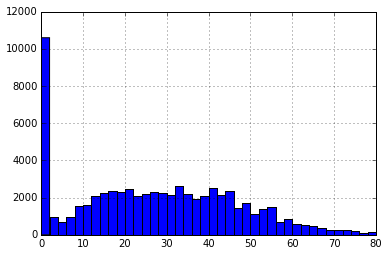

In [18]:
# how many stops were estimated for each trip data group?
pd.Series(lens).hist(range=(0,80),bins=40)

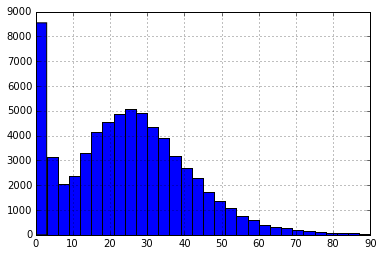

In [19]:
# how many pings were available for each trip data group?
gb.size().hist(range=(0,90),bins=30)